## Wrangle and analyze the WeRateDogs Twitter Data
### By Krishna Nadoor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests
import csv
import tweepy
import string
import json
import datetime
from tweepy import OAuthHandler
from timeit import default_timer as timer
from functools import reduce

%matplotlib inline

### Step 1 - Load the Data

In [2]:
# Import Twitter archive
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head(50)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [3]:
# Import Image Predictions
TSV_URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

try:
    response = requests.get(TSV_URL)
    with open('image_predictions_dl.tsv', 'w') as f:
        writer = csv.writer(f)
        for line in response.iter_lines():
            writer.writerow(line.decode('utf-8').split(','))
            
    # Alternatively, we could have just passed the URL to Pandas' read_csv function instead of using the
    # requests library
    df_predictions = pd.read_csv('image_predictions_dl.tsv', sep='\t')
    
except Exception:
    print("Error downloading the image predictions file from Udacity!")

    
df_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [4]:
# Query Twitter API for each tweet's JSON data
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = df_archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [5]:
# Import the Twitter JSON data
df_twitter = pd.read_json(r'tweet_json.txt', lines=True)
df_twitter.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [6]:
# Keep only the useful Twitter columns
cols = ['id', 'display_text_range', 'retweet_count', 'favorite_count']
df_twitter = df_twitter[cols]

df_twitter.head()

,id,display_text_range,retweet_count,favorite_count
0,892420643555336193,"[0, 85]",7352,35005
1,892177421306343426,"[0, 138]",5480,30322
2,891815181378084864,"[0, 121]",3624,22800
3,891689557279858688,"[0, 79]",7535,38278
4,891327558926688256,"[0, 138]",8120,36552


### Step 2 - Exploratory Data Analysis

#### df_archive

In [7]:
# Explore df_archive
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [8]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [9]:
df_archive.name.value_counts()

None       745
a           55
Charlie     12
Oliver      11
Lucy        11
          ... 
Crumpet      1
Blakely      1
Barclay      1
Maisey       1
Rorie        1
Name: name, Length: 957, dtype: int64

In [10]:
# Any rows duplicated?
df_archive.duplicated().any()

False

In [11]:
# Any null columns?
df_archive.isnull().any()

tweet_id                      False
in_reply_to_status_id          True
in_reply_to_user_id            True
timestamp                     False
source                        False
text                          False
retweeted_status_id            True
retweeted_status_user_id       True
retweeted_status_timestamp     True
expanded_urls                  True
rating_numerator              False
rating_denominator            False
name                          False
doggo                         False
floofer                       False
pupper                        False
puppo                         False
dtype: bool

In [12]:
df_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [13]:
# Select rows with tweets that has a '&amp;'
# ampersand
df_archive[df_archive.text.str.contains('&amp;')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
262,842765311967449089,NaN,NaN,2017-03-17 15:51:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Indie. She's not a fan of baths but she's...,NaN,NaN,NaN,"https://www.gofundme.com/get-indie-home/,https...",12,10,Indie,None,None,None,None
273,840728873075638272,NaN,NaN,2017-03-12 00:59:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Pipsy. He is a fluffbal...,6.671522e+17,4.196984e+09,2015-11-19 01:27:25 +0000,https://twitter.com/dog_rates/status/667152164...,12,10,Pipsy,None,None,None,None
320,834458053273591808,NaN,NaN,2017-02-22 17:41:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Chester (bottom) &amp; Harold (top). They...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/834458053...,12,10,Chester,None,None,None,None
461,817536400337801217,NaN,NaN,2017-01-07 01:00:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Eugene &amp; Patti Melt. No matte...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/817536400...,12,10,Eugene,None,None,None,None
485,814578408554463233,NaN,NaN,2016-12-29 21:06:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur ...,6.981954e+17,4.196984e+09,2016-02-12 17:22:12 +0000,https://twitter.com/dog_rates/status/698195409...,9,10,Beau,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
799,772826264096874500,NaN,NaN,2016-09-05 15:58:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Roosevelt. He's preparing for takeoff. Ma...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772826264...,11,10,Roosevelt,None,None,None,None
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,doggo,None,pupper,None
898,758854675097526272,NaN,NaN,2016-07-29 02:40:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lilli Bee &amp; Honey Bear. Unfortunat...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758854675...,11,10,Lilli,None,None,None,None
976,750026558547456000,NaN,NaN,2016-07-04 18:00:41 +0000,"<a href=""https://about.twitter.com/products/tw...",Meet Jax &amp; Jil. Jil is yelling the pledge ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750026558...,10,10,Jax,None,None,None,None


In [14]:
# Select rows with tweets that has a '&gt;'
# &gt; refers to the 'greater than' > sign.
df_archive[df_archive.text.str.contains('&gt;')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
274,840698636975636481,8.406983e+17,8.405479e+17,2017-03-11 22:59:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@0_kelvin_0 &gt;10/10 is reserved for puppos s...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None


In [15]:
df_archive.timestamp.head()

0    2017-08-01 16:23:56 +0000
1    2017-08-01 00:17:27 +0000
2    2017-07-31 00:18:03 +0000
3    2017-07-30 15:58:51 +0000
4    2017-07-29 16:00:24 +0000
Name: timestamp, dtype: object

In [16]:
# Checking if all Tweets really do have Ratings provided or not

# Regex to detect a rating of the form -> {number} / {number}
rating_regex = '[0-9]+\/[0-9]+'

#archive_copy[archive_copy['text'].str.contains(rating_regex)]

# Create a Pandas series for the dataframe's tweet text column
rating_series = pd.Series(df_archive.text)

# The str extract method is used to find the rating value using regex
rating = rating_series.str.extract(r'([0-9]+\/[0-9]+)', expand=True)

# Check for null records
print(rating.isnull().sum())

0    0
dtype: int64


In [17]:
# Display the full text of a Pandas dataframe
pd.set_option("display.max_colwidth", 1)

#### df_predictions

In [18]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
df_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [20]:
#Any null columns?
df_predictions.isnull().any()

tweet_id    False
jpg_url     False
img_num     False
p1          False
p1_conf     False
p1_dog      False
p2          False
p2_conf     False
p2_dog      False
p3          False
p3_conf     False
p3_dog      False
dtype: bool

In [21]:
# Any duplicated rows?
df_predictions.duplicated().sum()

0

#### df_twitter

In [22]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2331 non-null   int64 
 1   display_text_range  2331 non-null   object
 2   retweet_count       2331 non-null   int64 
 3   favorite_count      2331 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 73.0+ KB


In [23]:
df_twitter.describe()

,id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2587.162162,7310.145002
std,6.823170e+16,4376.372355,11353.953446
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,524.500000,1266.500000
50%,7.182469e+17,1206.000000,3171.000000
75%,7.986692e+17,2994.500000,8934.500000
max,8.924206e+17,74252.000000,150483.000000


In [24]:
#Any null columns?
df_twitter.isnull().any()

id                    False
display_text_range    False
retweet_count         False
favorite_count        False
dtype: bool

### Data Issues

#### Tidiness (2)

* df_archive:
  * Create a single ‘dog_stage’ column and remove the individual columns
* General:
  * Merge the three datasets after cleaning

#### Quality (15)
* df_twitter
  * id field to be renamed to twitter_id
* df_predictions
  * Remove the underscore ‘_’ from p1, p2, p3 
  * Capitalize the first letter of each word in p1, p2, p3
* df_archive
  * Using regex, match the ratings given in the tweets and fix the six incorrect numerator values
  * Create a single ‘rating’ field from merging the rating_numerator and rating_denominator fields
  * Drop useless NaN columns (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id,  retweeted_status_user_id, retweeted_status_timestamp
  * Split the timestamp field to two separate columns: time, date
  * Strip unnecessary HTML code from the source field
  * Delete ‘None’ from all rows in the ‘name’ field and replace with NaN
  * Delete the values from the ‘name’ field that matches with the following nine words: a; actually; all; an; by; quite; not; the; officially; and then replace with NaN
  * Convert the following fields from object to categorical data type: source, dog_stage
  * Replace '&amp', '&gt' and '\n' with &, > and a space, respectively, in the Tweets
  * Convert datatype to 'datetime' for the date column
* After data merge
  * Fill blanks with 0 for the columns: retweet_count and favorite_count
  * Convert datatype to 'int64' for the columns: retweet_count and favorite_count
  
  

### Step 3 - Data Cleaning

In [25]:
# Create a copy of the original dataframes to work on
twitter_copy = df_twitter.copy()
archive_copy = df_archive.copy()
predictions_copy = df_predictions.copy()

### Tidiness

#### (Issue 1) Create a single dog_stage column in the `archive` dataframe

#### Define

* Join all the dog stage columns into a single column
* Remove all 'None' text leaving only the dog stages

#### Code

In [26]:
# Join all the dog stages columns into one, separated by a space
archive_copy['dog_stage'] = archive_copy[['doggo','floofer','pupper','puppo']].apply(','.join, axis=1)
archive_copy.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,"None,None,None,None"
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,"None,None,None,None"
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None,"None,None,None,None"
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None,"None,None,None,None"
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None,"None,None,None,None"


In [27]:
# Find all unique rows in dog_stages
set(archive_copy['dog_stage'])

{'None,None,None,None',
 'None,None,None,puppo',
 'None,None,pupper,None',
 'None,floofer,None,None',
 'doggo,None,None,None',
 'doggo,None,None,puppo',
 'doggo,None,pupper,None',
 'doggo,floofer,None,None'}

In [28]:
# Perform cleaning operations
archive_copy['dog_stage'].replace("None,None,None,None","None", inplace=True)
archive_copy['dog_stage'].replace("None,None,None,puppo","puppo", inplace=True)
archive_copy['dog_stage'].replace("None,None,pupper,None","pupper", inplace=True)
archive_copy['dog_stage'].replace("None,floofer,None,None","floofer", inplace=True)
archive_copy['dog_stage'].replace("doggo,None,None,None","doggo", inplace=True)
archive_copy['dog_stage'].replace("doggo,None,None,puppo","multiple", inplace=True)
archive_copy['dog_stage'].replace("doggo,None,pupper,None","multiple", inplace=True)
archive_copy['dog_stage'].replace("doggo,floofer,None,None","multiple", inplace=True)

# Drop the excess dog stage columns
archive_copy.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'], inplace = True)

#### Test

In [29]:
set(archive_copy['dog_stage'])

{'None', 'doggo', 'floofer', 'multiple', 'pupper', 'puppo'}

In [30]:
archive_copy.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
1317,706593038911545345,NaN,NaN,2016-03-06 21:31:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a sneak peek of me on spring break. 10/10 so many tired pups these days https://t.co/6aJrjKfNqX,NaN,NaN,NaN,https://twitter.com/dog_rates/status/706593038911545345/photo/1,10,10,None,None
1982,672968025906282496,NaN,NaN,2015-12-05 02:37:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Gustaf. He's a purebred Chevy Equinox. Loves to shred. Gnarly lil pup. Great with the babes. 11/10 https://t.co/7CbO2eMAgJ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672968025906282496/photo/1,11,10,Gustaf,None
1072,739979191639244800,NaN,NaN,2016-06-07 00:36:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Nollie. She's waving at you. If you don't wave back you're a monster. She's also portable as hell. 12/10 https://t.co/7AKdkCOlMf,NaN,NaN,NaN,https://twitter.com/dog_rates/status/739979191639244800/photo/1,12,10,Nollie,None
1683,681694085539872773,NaN,NaN,2015-12-29 04:31:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bo. He's a Benedoop Cumbersnatch. Seems frustrated with own feet. Portable as hell. 11/10 very solid pupper https://t.co/TONMhRoQh7,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681694085539872773/photo/1,11,10,Bo,pupper
2343,666073100786774016,NaN,NaN,2015-11-16 01:59:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Let's hope this flight isn't Malaysian (lol). What a dog! Almost completely camouflaged. 10/10 I trust this pilot https://t.co/Yk6GHE9tOY,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666073100786774016/photo/1,10,10,None,None


### Quality

#### (Issue 1) id field to be renamed to tweet_id in the `twitter` dataframe

#### Define

* Rename the 'id' field to 'tweet_id'

#### Code

In [31]:
# Rename the column
col_rename = {'id':'tweet_id'}
twitter_copy.rename(columns = col_rename, inplace=True)

#### Test

In [32]:
twitter_copy.head()

,tweet_id,display_text_range,retweet_count,favorite_count
0,892420643555336193,"[0, 85]",7352,35005
1,892177421306343426,"[0, 138]",5480,30322
2,891815181378084864,"[0, 121]",3624,22800
3,891689557279858688,"[0, 79]",7535,38278
4,891327558926688256,"[0, 138]",8120,36552


#### (Issue 2) Remove underscores from p1, p2, p3 in the `predictions` dataframe

#### Define

* Remove the _ underscores between each word in the columns: p1, p2, p3

#### Code

In [33]:
# Remove the underscores
predictions_copy['p1'] = predictions_copy['p1'].str.replace('_',' ')
predictions_copy['p2'] = predictions_copy['p2'].str.replace('_',' ')
predictions_copy['p3'] = predictions_copy['p3'].str.replace('_',' ')

#### Test

In [34]:
predictions_copy.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh springer spaniel,0.465074,True,collie,0.156665,True,Shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature pinscher,0.074192,True,Rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### (Issue 3) Capitalize the first letter of each word in p1, p2, p3 in the `predictions` dataframe

#### Define

* Capitalize the first letter of each word in the columns: p1, p2, p3

#### Code

In [35]:
# Capitalize the first letter of each word
predictions_copy['p1'] = predictions_copy['p1'].str.title()
predictions_copy['p2'] = predictions_copy['p2'].str.title()
predictions_copy['p3'] = predictions_copy['p3'].str.title()

#### Test

In [36]:
predictions_copy.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
603,679844490799091713,https://pbs.twimg.com/media/CW9K9VeVAAE0j-x.jpg,1,Airedale,0.903832,True,Border Terrier,0.034713,True,Toy Poodle,0.021378,True
572,678410210315247616,https://pbs.twimg.com/media/CWoyfMiWUAAmGdd.jpg,1,Schipperke,0.145877,True,Labrador Retriever,0.098354,True,Kelpie,0.097393,True
97,667728196545200128,https://pbs.twimg.com/media/CUQ_QahUAAAVQjn.jpg,1,Kuvasz,0.360159,True,Golden Retriever,0.293744,True,Labrador Retriever,0.270673,True
134,668484198282485761,https://pbs.twimg.com/media/CUbu1GAWsAEH3E-.jpg,1,Standard Poodle,0.587372,True,Bedlington Terrier,0.182411,True,Afghan Hound,0.040968,True
1431,773247561583001600,https://pbs.twimg.com/media/Crsgi9dWEAApQd8.jpg,1,Seat Belt,0.713588,False,Miniature Pinscher,0.083369,True,Brabancon Griffon,0.075696,True


#### (Issue 4) Fix incorrect numerator ratings in the `archive` dataframe

#### Define

* Using regex, match the ratings given in the tweets and fix the six incorrect numerator values

#### Code

In [37]:
# Find all affected records
archive_copy[archive_copy.text.str.contains(r'(\d+\.\d*\/\d+)')][['tweet_id','text', 'rating_numerator', 'rating_denominator']]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5,10
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


In [38]:
# List of affected Tweets by Tweet ID
tweet_id = archive_copy[archive_copy.text.str.contains( r'(\d+\.\d+)/(\d+)')]['tweet_id'].tolist()

# List of the correct numerators from the Tweets
correct_numerator = archive_copy['text'].str.extract( r'(\d+\.\d+)/(\d+)')[0].dropna().tolist()

# Use Dictionary Comprehension to convert lists to Dictionary
num_dict = {tweet_id[i]: correct_numerator[i] for i in range(len(tweet_id))} 
num_dict

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


{883482846933004288: '13.5',
 832215909146226688: '9.75',
 786709082849828864: '9.75',
 778027034220126208: '11.27',
 681340665377193984: '9.5',
 680494726643068929: '11.26'}

In [39]:
# Update the incorrect numerators with the correct ones
archive_copy.loc[archive_copy['tweet_id'].isin(num_dict.keys()), 
                 'rating_numerator'] = archive_copy['tweet_id'].map(num_dict)

#### Test

In [40]:
archive_copy[archive_copy.text.str.contains(r'(\d+\.\d*\/\d+)')][['tweet_id','text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.5,10
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",9.75,10
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,9.5,10
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10


#### (Issue 5) Create a single ‘rating’ field in the `archive` dataframe

#### Define

* Join the numerator and denominator columns into one
* The values will be separated by a ' / '
* Drop the existing numerator and denominator fields

#### Code

In [41]:
# Convert fields to string type
archive_copy['rating_numerator'] = archive_copy['rating_numerator'].astype(str)
archive_copy['rating_denominator'] = archive_copy['rating_denominator'].astype(str)

# Join all the dog stages columns into one, separated by a space
archive_copy['rating'] = archive_copy[['rating_numerator','rating_denominator']].apply('/'.join, axis=1)

# Drop the numerator and denominator fields
archive_copy.drop(columns = ['rating_numerator', 'rating_denominator'], inplace = True)

#### Test

In [42]:
archive_copy.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,dog_stage,rating
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,Phineas,None,13/10
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,Tilly,None,13/10
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,Archie,None,12/10
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,Darla,None,13/10
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",Franklin,None,12/10


#### (Issue 6) Drop useless fields from the `archive` dataframe

#### Define

* Drop the following fields that have no data:
  * in_reply_to_status_id
  * in_reply_to_user_id
  * retweeted_status_id
  * retweeted_status_user_id
  * retweeted_status_timestamp

#### Code

In [43]:
# Drop the numerator and denominator fields
drop_cols = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']
archive_copy.drop(columns = drop_cols, inplace = True)

#### Test

In [44]:
archive_copy.head()

,tweet_id,timestamp,source,text,expanded_urls,name,dog_stage,rating
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,Phineas,None,13/10
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,Tilly,None,13/10
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,Archie,None,12/10
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,Darla,None,13/10
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",Franklin,None,12/10


#### (Issue 7) Format timestamp in the `archive` dataframe to only show the date

#### Define

* Remove the 'time' from the timestamp column ensuring that only the date exists
* Ensure format of the column is datetime

#### Code

In [45]:
# Convert the timestamp column to date time
archive_copy['timestamp'] = pd.to_datetime(archive_copy['timestamp'])

archive_copy['date'] = [d.date() for d in archive_copy['timestamp']]
archive_copy['time'] = [d.time() for d in archive_copy['timestamp']]

In [46]:
# Drop the old timestamp column
archive_copy.drop(columns = 'timestamp', inplace = True)

#### Test

In [47]:
archive_copy.head()

,tweet_id,source,text,expanded_urls,name,dog_stage,rating,date,time
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,Phineas,None,13/10,2017-08-01,16:23:56
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,Tilly,None,13/10,2017-08-01,00:17:27
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,Archie,None,12/10,2017-07-31,00:18:03
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,Darla,None,13/10,2017-07-30,15:58:51
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",Franklin,None,12/10,2017-07-29,16:00:24


#### (Issue 8) Clean the source field in the `archive` dataframe

#### Define

* Strip out the HTML script from the source field

#### Code

In [48]:
# Use Regex to strip out HTML source code
# https://stackoverflow.com/questions/753052/strip-html-from-strings-in-python
archive_copy['source'] = archive_copy['source'].str.replace(r'<[^<]+?>', "")

#### Test

In [49]:
set(archive_copy['source'])

{'TweetDeck',
 'Twitter Web Client',
 'Twitter for iPhone',
 'Vine - Make a Scene'}

In [50]:
archive_copy.head()

,tweet_id,source,text,expanded_urls,name,dog_stage,rating,date,time
0,892420643555336193,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,Phineas,None,13/10,2017-08-01,16:23:56
1,892177421306343426,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,Tilly,None,13/10,2017-08-01,00:17:27
2,891815181378084864,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,Archie,None,12/10,2017-07-31,00:18:03
3,891689557279858688,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,Darla,None,13/10,2017-07-30,15:58:51
4,891327558926688256,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",Franklin,None,12/10,2017-07-29,16:00:24


#### (Issue 9) Replace None with NaN for the name column in `archive` dataframe

#### Define

* Replace None with NaN for all matching name records

#### Code

In [51]:
# Replace None with NaN
archive_copy['name'] = archive_copy['name'].replace('None', np.NaN)

#### Test

In [52]:
# Checking for None
(archive_copy['name'] == 'None').sum()

0

In [53]:
# Checking for NaN
archive_copy['name'].sample(10)

406     Balto 
885     NaN   
1017    a     
2042    Baxter
1240    Olive 
1291    Cooper
1339    NaN   
424     Harlso
938     Ace   
934     NaN   
Name: name, dtype: object

#### (Issue 10) Delete incorrect values from the name column in `archive` dataframe

#### Define
* Replace the following incorrect names with NaN: a, actually, all, officially

#### Code

In [54]:
# Return number and list of affected rows with bad names
print(archive_copy[archive_copy['name'].isin(['a', 'actually', 'all','an','by','quite','not','officially'])].shape[0])

archive_copy[archive_copy.text.isin(['a', 'actually', 'all','an','by','quite','not','officially'])]

73


,tweet_id,source,text,expanded_urls,name,dog_stage,rating,date,time


In [55]:
# Perform cleaning action
pattern = ['a', 'actually', 'all', 'an', 'by', 'quite', 'not', 'officially','the']

for name in pattern:
    archive_copy['name'] = archive_copy['name'].replace(name, np.NaN)

#### Test

In [56]:
archive_copy[archive_copy['name'].isin(['a', 'actually', 'all','an','by','quite','not','officially','the'])].shape[0]

0

#### (Issue 11) Convert relevant columns to categorical datatype in `archive` dataframe

#### Define

* The following columns are to be converted to categorical data type:
  * source
  * dog_stage

#### Code

In [57]:
# Perform the datatype conversion
category_convert = ['source', 'dog_stage']

for item in category_convert:
    archive_copy[item] = archive_copy[item].astype('category')

#### Test

In [58]:
archive_copy.source.dtype == 'category'

True

In [59]:
archive_copy.dog_stage.dtype == 'category'

True

#### (Issue 12) Clean up Tweets (&amp, &gt, \n) in the `archive` dataframe

#### Define

* Convert all "&amp" in the tweets to the correct symbol: &
* Convert all "&gt" in the tweets to the correct symbol: >

#### Code

In [60]:
# Check affected records
print(archive_copy[archive_copy['text'].str.contains('&amp;')].shape[0])
archive_copy[archive_copy['text'].str.contains('&amp;')]

54


,tweet_id,source,text,expanded_urls,name,dog_stage,rating,date,time
262,842765311967449089,Twitter for iPhone,Meet Indie. She's not a fan of baths but she's definitely a fan of hide &amp; seek. 12/10 click the link to help Indie\n\nhttps://t.co/fvGkIuAlFK https://t.co/kiCFtmJd7l,"https://www.gofundme.com/get-indie-home/,https://twitter.com/dog_rates/status/842765311967449089/photo/1,https://twitter.com/dog_rates/status/842765311967449089/photo/1",Indie,None,12/10,2017-03-17,15:51:22
273,840728873075638272,Twitter for iPhone,RT @dog_rates: This is Pipsy. He is a fluffball. Enjoys traveling the sea &amp; getting tangled in leash. 12/10 I would kill for Pipsy https://…,https://twitter.com/dog_rates/status/667152164079423490/photo/1,Pipsy,None,12/10,2017-03-12,00:59:17
320,834458053273591808,Twitter for iPhone,"Meet Chester (bottom) &amp; Harold (top). They are different dogs not only in appearance, but in personality as well. Both 12/10 symbiotic af https://t.co/8ZOZS2FSJe",https://twitter.com/dog_rates/status/834458053273591808/photo/1,Chester,None,12/10,2017-02-22,17:41:18
461,817536400337801217,Twitter for iPhone,"Say hello to Eugene &amp; Patti Melt. No matter how dysfunctional they get, they will never top their owners. Both 12/10 would pet at same time https://t.co/jQUdvtdYMu","https://twitter.com/dog_rates/status/817536400337801217/photo/1,https://twitter.com/dog_rates/status/817536400337801217/photo/1,https://twitter.com/dog_rates/status/817536400337801217/photo/1,https://twitter.com/dog_rates/status/817536400337801217/photo/1",Eugene,None,12/10,2017-01-07,01:00:41
485,814578408554463233,Twitter for iPhone,RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur stole Beau's bed from him. Wilbur now has so much room for activities. 9/10 for both pups https:/…,https://twitter.com/dog_rates/status/698195409219559425/photo/1,Beau,None,9/10,2016-12-29,21:06:41
516,810984652412424192,Twitter for iPhone,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",Sam,None,24/7,2016-12-19,23:06:23
799,772826264096874500,Twitter for iPhone,Meet Roosevelt. He's preparing for takeoff. Make sure tray tables are in their full pupright &amp; licked position\n11/10 https://t.co/7CQkn3gHOQ,https://twitter.com/dog_rates/status/772826264096874500/photo/1,Roosevelt,None,11/10,2016-09-05,15:58:34
889,759793422261743616,Twitter for iPhone,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll","https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1",Maggie,multiple,12/10,2016-07-31,16:50:42
898,758854675097526272,Twitter for iPhone,"This is Lilli Bee &amp; Honey Bear. Unfortunately, they were both born with no eyes. So heckin sad. Both 11/10 https://t.co/4UrfOZhztW","https://twitter.com/dog_rates/status/758854675097526272/photo/1,https://twitter.com/dog_rates/status/758854675097526272/photo/1,https://twitter.com/dog_rates/status/758854675097526272/photo/1,https://twitter.com/dog_rates/status/758854675097526272/photo/1",Lilli,None,11/10,2016-07-29,02:40:28
976,750026558547456000,TweetDeck,Meet Jax &amp; Jil. Jil is yelling the pledge of allegiance. If u cant take the freedom get out the kitchen Jax. 10/10s https://t.co/jrg29NDNhI,https://twitter.com/dog_rates/status/750026558547456000/photo/1,Jax,None,10/10,2016-07-04,18:00:41


In [61]:
print(archive_copy[archive_copy['text'].str.contains('&gt;')].shape[0])
archive_copy[archive_copy['text'].str.contains('&gt;')]

2


,tweet_id,source,text,expanded_urls,name,dog_stage,rating,date,time
113,870726314365509632,Twitter for iPhone,@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,None,10/10,2017-06-02,19:38:25
274,840698636975636481,Twitter for iPhone,@0_kelvin_0 &gt;10/10 is reserved for puppos sorry Kevin,NaN,NaN,None,10/10,2017-03-11,22:59:09


In [62]:
print(archive_copy[archive_copy['text'].str.contains('\n')].shape[0])
archive_copy[archive_copy['text'].str.contains('\n')]

95


,tweet_id,source,text,expanded_urls,name,dog_stage,rating,date,time
6,890971913173991426,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",Jax,None,13/10,2017-07-28,16:27:12
27,886736880519319552,Twitter for iPhone,"This is Mingus. He's a wonderful father to his smol pup. Confirmed 13/10, but he needs your help\n\nhttps://t.co/bVi0Yr4Cff https://t.co/ISvKOSkd5b","https://www.gofundme.com/mingusneedsus,https://twitter.com/dog_rates/status/886736880519319552/photo/1,https://twitter.com/dog_rates/status/886736880519319552/photo/1",Mingus,None,13/10,2017-07-16,23:58:41
56,881536004380872706,Twitter for iPhone,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,https://twitter.com/dog_rates/status/881536004380872706/video/1,NaN,pupper,14/10,2017-07-02,15:32:16
73,878404777348136964,Twitter for iPhone,"RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…","https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",Shadow,None,13/10,2017-06-24,00:09:53
75,878281511006478336,Twitter for iPhone,"Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps://t.co/245xJJElsY https://t.co/lUiQH219v6","https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",Shadow,None,13/10,2017-06-23,16:00:04
...,...,...,...,...,...,...,...,...,...
2155,669603084620980224,Twitter for iPhone,Very human-like. Cute overbite smile *finger to earpiece* I'm being told that the dog is actually on the right\n10/10 https://t.co/MSIbWu4YYs,https://twitter.com/dog_rates/status/669603084620980224/photo/1,NaN,None,10/10,2015-11-25,19:46:30
2189,668967877119254528,Twitter for iPhone,12/10 good shit Bubka\n@wane15,NaN,NaN,None,12/10,2015-11-24,01:42:25
2250,667832474953625600,Twitter for iPhone,THE EYES 12/10\n\nI'm sorry. These are supposed to be funny but your dogs are too adorable https://t.co/z1xPTgVLc7,https://twitter.com/dog_rates/status/667832474953625600/photo/1,NaN,None,12/10,2015-11-20,22:30:44
2264,667538891197542400,Twitter Web Client,This is a southwest Coriander named Klint. Hat looks expensive. Still on house arrest :(\n9/10 https://t.co/IQTOMqDUIe,https://twitter.com/dog_rates/status/667538891197542400/photo/1,NaN,None,9/10,2015-11-20,03:04:08


In [63]:
# Perform clean-up
tweet_cleanup = ['&amp;','&gt;','\n']

for symbol in tweet_cleanup:
    if symbol == '&amp;':
        archive_copy['text'] = archive_copy['text'].str.replace(symbol, '&')
    elif symbol == '&gt;':
        archive_copy['text'] = archive_copy['text'].str.replace(symbol, '>')
    else:
        archive_copy['text'] = archive_copy['text'].str.replace(symbol, ' ')

#### Test

In [64]:
print(archive_copy[archive_copy['text'].str.contains('&amp;')].shape[0])
print(archive_copy[archive_copy['text'].str.contains('&gt;')].shape[0])
print(archive_copy[archive_copy['text'].str.contains('\n')].shape[0])

0
0
0


In [65]:
# Validating against previously affected records (first row)
# Checking that &amp; has been replaced with &
archive_copy.iloc[262][2]

"Meet Indie. She's not a fan of baths but she's definitely a fan of hide & seek. 12/10 click the link to help Indie  https://t.co/fvGkIuAlFK https://t.co/kiCFtmJd7l"

In [66]:
# Checking that &gt; has been replaced with >
archive_copy.iloc[113][2]

'@ComplicitOwl @ShopWeRateDogs >10/10 is reserved for dogs'

In [67]:
# Checking that \n has been replaced with a space
archive_copy.iloc[6][2]

'Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below  https://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl'

#### (Issue 13) Update datatypes in `archive` dataframe

#### Define

* Convert datatype to 'date' for the date column

#### Code

In [68]:
archive_copy['date'] = pd.to_datetime(archive_copy['date'])

#### Test

In [69]:
archive_copy['date'].dtype

dtype('<M8[ns]')

### Step 4 - Data Merge and final clean-up

In [70]:
frames = [archive_copy, twitter_copy, predictions_copy]
df = reduce(lambda left, right: pd.merge(left, right, on=['tweet_id'], how='outer'), frames)

#### (Issue 14) Fill blanks with 0 in `master` dataframe

#### Define

* Fill blank cells with 0 for retweet_count and favorite_count columns

#### Code

In [71]:
df.retweet_count.fillna(0, inplace=True)
df.favorite_count.fillna(0, inplace=True)

#### Test

In [72]:
print(df.favorite_count.isnull().sum())
print(df.retweet_count.isnull().sum())

0
0


#### (Issue 15) Convert columns to int64 in `master` dataframe

#### Define

* Convert datatype to 'int64' for the columns: favorite_count, retweet_count

#### Code

In [73]:
df['retweet_count'] = df['retweet_count'].astype(np.int64)
df['favorite_count'] = df['favorite_count'].astype(np.int64)

#### Test

In [74]:
df['retweet_count'].dtype

dtype('int64')

In [75]:
df['favorite_count'].dtype

dtype('int64')

#### Create the master CSV file

In [76]:
df.to_csv("twitter_archive_master.csv", index=False)

### Step 5 - Data Analysis and Visualization

In [77]:
df.head()

,tweet_id,source,text,expanded_urls,name,dog_stage,rating,date,time,display_text_range,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,Phineas,None,13/10,2017-08-01,16:23:56,"[0, 85]",...,1.0,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,Tilly,None,13/10,2017-08-01,00:17:27,"[0, 138]",...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,Archie,None,12/10,2017-07-31,00:18:03,"[0, 121]",...,1.0,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,Darla,None,13/10,2017-07-30,15:58:51,"[0, 79]",...,1.0,Paper Towel,0.170278,False,Labrador Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",Franklin,None,12/10,2017-07-29,16:00:24,"[0, 138]",...,2.0,Basset,0.555712,True,English Springer,0.225770,True,German Short-Haired Pointer,0.175219,True


In [78]:
df.tail()

,tweet_id,source,text,expanded_urls,name,dog_stage,rating,date,time,display_text_range,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2351,666049248165822465,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,https://twitter.com/dog_rates/status/666049248165822465/photo/1,NaN,None,5/10,2015-11-16,00:24:50,"[0, 120]",...,1.0,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
2352,666044226329800704,Twitter for iPhone,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,https://twitter.com/dog_rates/status/666044226329800704/photo/1,NaN,None,6/10,2015-11-16,00:04:52,"[0, 137]",...,1.0,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True
2353,666033412701032449,Twitter for iPhone,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,https://twitter.com/dog_rates/status/666033412701032449/photo/1,NaN,None,9/10,2015-11-15,23:21:54,"[0, 130]",...,1.0,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
2354,666029285002620928,Twitter for iPhone,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,https://twitter.com/dog_rates/status/666029285002620928/photo/1,NaN,None,7/10,2015-11-15,23:05:30,"[0, 139]",...,1.0,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True
2355,666020888022790149,Twitter for iPhone,Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,https://twitter.com/dog_rates/status/666020888022790149/photo/1,NaN,None,8/10,2015-11-15,22:32:08,"[0, 131]",...,1.0,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2356 non-null   int64         
 1   source              2356 non-null   category      
 2   text                2356 non-null   object        
 3   expanded_urls       2297 non-null   object        
 4   name                1530 non-null   object        
 5   dog_stage           2356 non-null   category      
 6   rating              2356 non-null   object        
 7   date                2356 non-null   datetime64[ns]
 8   time                2356 non-null   object        
 9   display_text_range  2331 non-null   object        
 10  retweet_count       2356 non-null   int64         
 11  favorite_count      2356 non-null   int64         
 12  jpg_url             2075 non-null   object        
 13  img_num             2075 non-null   float64     

In [80]:
df.describe()

,tweet_id,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,2.356000e+03,2356.000000,2356.000000,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.427716e+17,2559.709253,7232.575552,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.856705e+16,4361.148639,11318.349203,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,0.000000,0.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.783989e+17,507.000000,1214.750000,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.196279e+17,1190.000000,3138.500000,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.993373e+17,2976.250000,8826.500000,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,74252.000000,150483.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


In [81]:
# Number of nulls in each column
df.isnull().sum()

tweet_id              0  
source                0  
text                  0  
expanded_urls         59 
name                  826
dog_stage             0  
rating                0  
date                  0  
time                  0  
display_text_range    25 
retweet_count         0  
favorite_count        0  
jpg_url               281
img_num               281
p1                    281
p1_conf               281
p1_dog                281
p2                    281
p2_conf               281
p2_dog                281
p3                    281
p3_conf               281
p3_dog                281
dtype: int64

In [82]:
# Frequency count of sources used to tweet
df.source.value_counts()

Twitter for iPhone     2221
Vine - Make a Scene    91  
Twitter Web Client     33  
TweetDeck              11  
Name: source, dtype: int64

In [83]:
# Frequency count of dog names
df.name.value_counts()

Charlie    12
Oliver     11
Cooper     11
Lucy       11
Lola       10
           ..
Blakely    1 
Barclay    1 
Maisey     1 
Maya       1 
Rorie      1 
Name: name, Length: 947, dtype: int64

In [84]:
# Frequency count of dog stages
df.dog_stage.value_counts()

None        1976
pupper      245 
doggo       83  
puppo       29  
multiple    14  
floofer     9   
Name: dog_stage, dtype: int64

In [85]:
# Frequency of hours (which times were most popular when posting?)
(pd.to_datetime(df.time, format='%H:%M:%S').dt.hour).value_counts()

1     328
0     291
2     255
16    214
3     199
17    188
18    124
23    123
4     112
19    106
15    99 
20    95 
21    87 
22    84 
5     30 
14    9  
13    5  
6     5  
12    2  
Name: time, dtype: int64

In [86]:
# Frequency of the Top 10 most popular dog breeds (using first prediction column)
breeds = df.p1.value_counts().head(10)
breeds

Golden Retriever      150
Labrador Retriever    100
Pembroke              89 
Chihuahua             83 
Pug                   57 
Chow                  44 
Samoyed               43 
Toy Poodle            39 
Pomeranian            38 
Malamute              30 
Name: p1, dtype: int64

#### Visualizations

In [87]:
# Set Seaborn style and color
sb.set_style("whitegrid")
color = sb.color_palette()[9]

Let's plot the 10 most popular dog breeds as identified by the machine learning model.

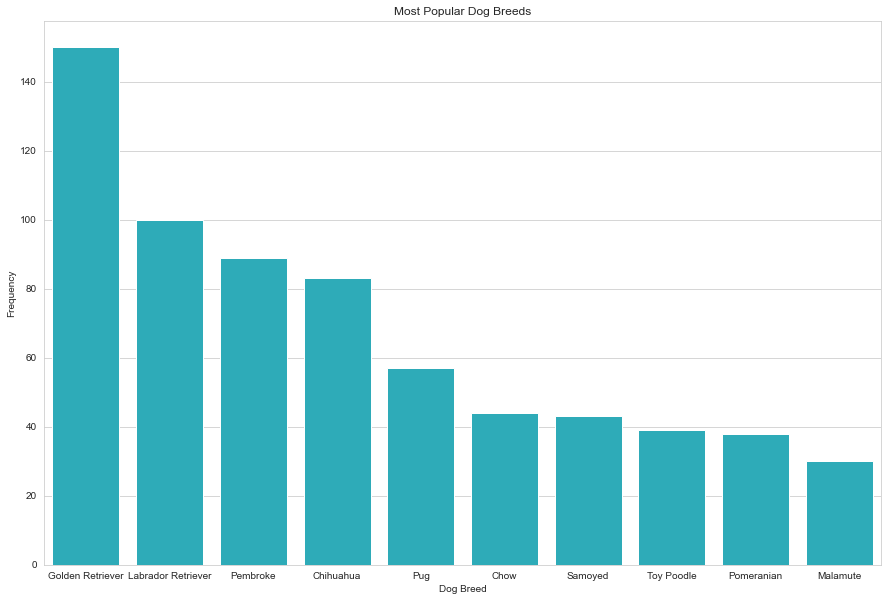

In [88]:
plt.figure(figsize = [15,10])
sb.countplot(data = df, x = df.p1, color = color, order=df.p1.value_counts().iloc[:10].index)
plt.title("Most Popular Dog Breeds")
plt.ylabel("Frequency")
plt.xlabel("Dog Breed");

Let's now find out the most popular platform to post the dog Tweets!

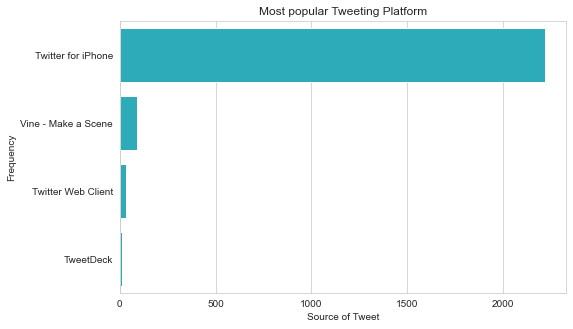

In [89]:
plt.figure(figsize = [8,5])
sb.countplot(data = df, y = df.source, color = color, order=df.source.value_counts().iloc[:4].index)
plt.title("Most popular Tweeting Platform")
plt.ylabel("Frequency")
plt.xlabel("Source of Tweet");

Let's find out the most popular dog names...

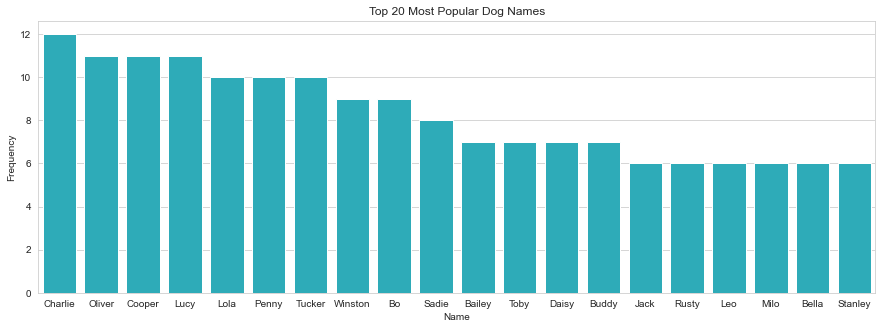

In [90]:
plt.figure(figsize = [15,5])
sb.countplot(data = df, x = df.name, color = color, order=df.name.value_counts().iloc[:20].index)
plt.title("Top 20 Most Popular Dog Names")
plt.ylabel("Frequency")
plt.xlabel("Name");

Now, let's find out what are the best times and days to post a Tweet to get maximum 'likes':

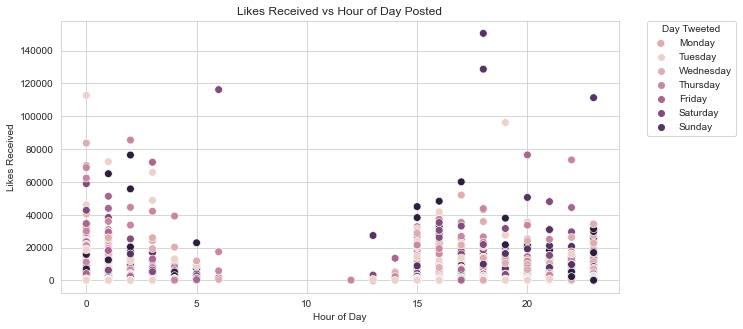

In [91]:
# Return the 'hour' of each time record
df['hour_posted'] = pd.to_datetime(df.time, format='%H:%M:%S').dt.hour

# Return the day posted (0 = Monday, 6 = Sunday)
df['day_posted'] = pd.to_datetime(df.date).dt.dayofweek

plt.figure(figsize = [10,5])
sb.scatterplot(data=df, x="hour_posted", y="favorite_count", x_jitter=0.5, hue="day_posted", s=60)

plt.title("Likes Received vs Hour of Day Posted")
plt.ylabel("Likes Received")
plt.xlabel("Hour of Day")
plt.legend(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], title='Day Tweeted',
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0);